## Import the necessary libraries.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons  # Importing dataset generator
from sklearn.model_selection import train_test_split  # Splitting dataset into training and testing sets

# Generate and preprocess the dataset.

In [8]:
def generate_dataset():
    X, y = make_moons(n_samples=500, noise=0.2, random_state=42)  # Generate dataset
    y = y.reshape(-1, 1)  # Reshape labels to column vector
    return X, y

## Define Activation Functions.

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))  # Sigmoid function

def sigmoid_derivative(x):
    return x * (1 - x)  # Derivative of Sigmoid (for backpropagation)

def relu(x):
    return np.maximum(0, x)  # ReLU activation function

def relu_derivative(x):
    return (x > 0).astype(float)  # Derivative of ReLU (used for backpropagation)

## Define Neural network.

In [17]:
class NeuralNetwork:
    def __init__(self, input_neurons, hidden_neurons, hidden_neurons2, output_neurons, learning_rate=0.5, decay_rate=0.001):
        self.learning_rate = learning_rate  # Initial learning rate
        self.decay_rate = decay_rate  # Learning rate decay factor

        # Initializing weights and biases using small random values
        self.weights_input_hidden = np.random.uniform(-1, 1, (input_neurons, hidden_neurons))
        self.bias_hidden = np.zeros((1, hidden_neurons))

        self.weights_hidden_hidden = np.random.uniform(-1, 1, (hidden_neurons, hidden_neurons2))
        self.bias_hidden2 = np.zeros((1, hidden_neurons2))

        self.weights_hidden_output = np.random.uniform(-1, 1, (hidden_neurons2, output_neurons))
        self.bias_output = np.zeros((1, output_neurons))

    # Forward propagation: Computes activations through the network
    def forward_propagation(self, X):
        self.input_layer = X  # Input layer
        self.hidden_layer1 = relu(np.dot(self.input_layer, self.weights_input_hidden) + self.bias_hidden)  # Hidden layer 1
        self.hidden_layer2 = relu(np.dot(self.hidden_layer1, self.weights_hidden_hidden) + self.bias_hidden2)  # Hidden layer 2
        self.output_layer = sigmoid(np.dot(self.hidden_layer2, self.weights_hidden_output) + self.bias_output)  # Output layer
        return self.output_layer

    # Backpropagation: Computes gradients and updates weights
    def backward_propagation(self, X, y):
        # Compute error at the output layer
        output_error = y - self.output_layer
        output_delta = output_error * sigmoid_derivative(self.output_layer)

        # Compute error for second hidden layer
        hidden_error2 = np.dot(output_delta, self.weights_hidden_output.T)
        hidden_delta2 = hidden_error2 * relu_derivative(self.hidden_layer2)

        # Compute error for first hidden layer
        hidden_error1 = np.dot(hidden_delta2, self.weights_hidden_hidden.T)
        hidden_delta1 = hidden_error1 * relu_derivative(self.hidden_layer1)

        # Update weights and biases using Gradient Descent
        self.weights_hidden_output += self.learning_rate * np.dot(self.hidden_layer2.T, output_delta)
        self.bias_output += self.learning_rate * np.sum(output_delta, axis=0, keepdims=True)

        self.weights_hidden_hidden += self.learning_rate * np.dot(self.hidden_layer1.T, hidden_delta2)
        self.bias_hidden2 += self.learning_rate * np.sum(hidden_delta2, axis=0, keepdims=True)

        self.weights_input_hidden += self.learning_rate * np.dot(self.input_layer.T, hidden_delta1)
        self.bias_hidden += self.learning_rate * np.sum(hidden_delta1, axis=0, keepdims=True)

    # Training function with Mini-Batch Gradient Descent and Early Stopping
    def train(self, X, y, epochs=1000, batch_size=32, early_stopping_threshold=1e-5):
        loss_values = []  # Store loss values for visualization
        prev_loss = float('inf')  # Initialize previous loss for early stopping

        for epoch in range(epochs):
            # Shuffle data at the beginning of each epoch
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            X, y = X[indices], y[indices]

            # Mini-Batch Gradient Descent
            for i in range(0, len(X), batch_size):
                batch_X = X[i:i+batch_size]
                batch_y = y[i:i+batch_size]
                self.forward_propagation(batch_X)
                self.backward_propagation(batch_X, batch_y)

            # Compute loss for monitoring
            predictions = self.forward_propagation(X)
            loss = np.mean(-(y * np.log(predictions) + (1 - y) * np.log(1 - predictions)))
            loss_values.append(loss)

            # Adjust learning rate using decay
            self.learning_rate = self.learning_rate / (1 + self.decay_rate * epoch)

            # Print progress every 100 epochs
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {loss:.5f}")

            # Early stopping condition
            if epoch > 50 and abs(prev_loss - loss) < early_stopping_threshold:
                print(f"Early stopping at epoch {epoch}")
                break

            prev_loss = loss  # Update previous loss

        return loss_values

    # Prediction function
    def predict(self, X):
        predictions = self.forward_propagation(X)
        return (predictions > 0.5).astype(int)  # Convert probabilities to binary labels

## Visualize decision boundry.

In [18]:
# Function to visualize the decision boundary
def visualize_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    grid = np.c_[xx.ravel(), yy.ravel()]
    predictions = model.predict(grid).reshape(xx.shape)

    plt.contourf(xx, yy, predictions, cmap=plt.cm.Spectral, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap=plt.cm.Spectral, edgecolors='k')
    plt.title("Neural Network Decision Boundary")
    plt.show()

## Train the neural network.

In [19]:
def execute_neural_network():
    # Load and split dataset
    X, y = generate_dataset()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define network parameters
    input_neurons = X.shape[1]
    hidden_neurons = 6  # First hidden layer
    hidden_neurons2 = 4  # Second hidden layer
    output_neurons = 1
    learning_rate = 0.1
    decay_rate = 0.001

    # Initialize neural network
    nn = NeuralNetwork(input_neurons, hidden_neurons, hidden_neurons2, output_neurons, learning_rate, decay_rate)

    # Train the model
    loss_values = nn.train(X_train, y_train, epochs=1000, batch_size=32)

    # Plot loss curve
    plt.plot(loss_values)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.show()

    # Visualize decision boundary
    visualize_decision_boundary(nn, X, y)

## Output

Epoch 0: Loss = 0.34589
Early stopping at epoch 72


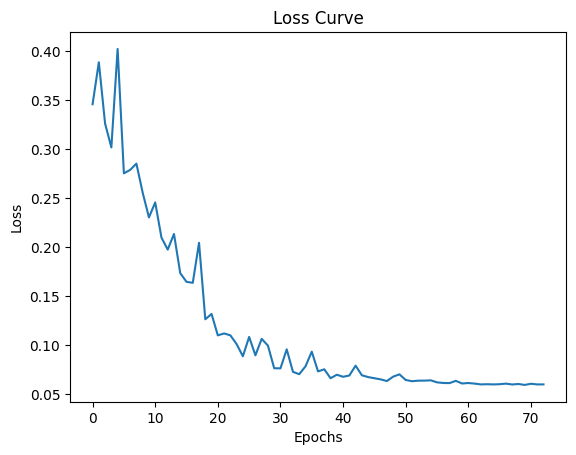

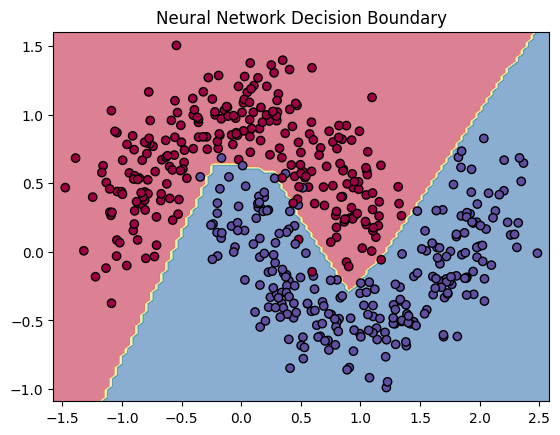

In [20]:
execute_neural_network()